<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# Musterlösung / Sample solution 
## 10th exercise: <font color="#C70039">Interpretable Machine Learning with Shapley Values for image classification</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   13.07.2022

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
This is one implementation example to demo XAI for image classification using the inbuild cifar-10 data set, that you have come across with in exercise 8 already.

## Imports
Import all necessary utilities.

In [1]:
import shap
import numpy as np
import tensorflow as tf
from   tensorflow import keras
import matplotlib.pyplot as plt
from   tensorflow.keras.models import Sequential
import ssl

## load build-in dataset
take the cifar-10 data set from exercise 8

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# reshape and normalize data
x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)

### Build a simple CNN, compile and fit the model.

In [3]:
'''### UMBAUEN !!!
-------------------
'''

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

# inputs and outputs
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="test_for_shap")
# compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )
#model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10)

Metal device set to: Apple M1


2022-12-06 10:29:18.016786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-06 10:29:18.016874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.summary()

Model: "test_for_shap"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 256)               1843456   
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                     

### predict on the test set (one image for each class).

In [5]:
# class label list
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# example image for each class
images_dict = dict()

for i, l in enumerate(y_train):
    if len(images_dict)==10:
        break
    if l not in images_dict.keys():
        images_dict[l] = x_train[i].reshape((32, 32,3))
images_dict = dict(sorted(images_dict.items()))
    
# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
    if len(x_test_dict)==10:
        break
    if l not in x_test_dict.keys():
        x_test_dict[l] = x_test[i]
        
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

2022-12-06 10:29:18.335742: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-06 10:29:18.374229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 284ms/step


### Visualization
#### plot function
define a plot function for actual and predicted class.

In [6]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
    fig, axes = plt.subplots(1, 11, figsize=(16, 15))
    axes = axes.flatten()
  
    # plot
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("Base reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')
    
    # plot image
    for k,v in images.items():
        ax = axes[k+1]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
        ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

#### XAI using SHAP
Now use the SHAP library to generate the Shapley values

In [7]:
# select background for shap
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]

# use DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)

# compute the shapley values
shap_values = explainer.shap_values(x_test_each_class)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2022-12-06 10:29:21.619198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 10:29:25.746873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 10:29:29.574214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 10:29:33.402527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

#### plot the Shapley values

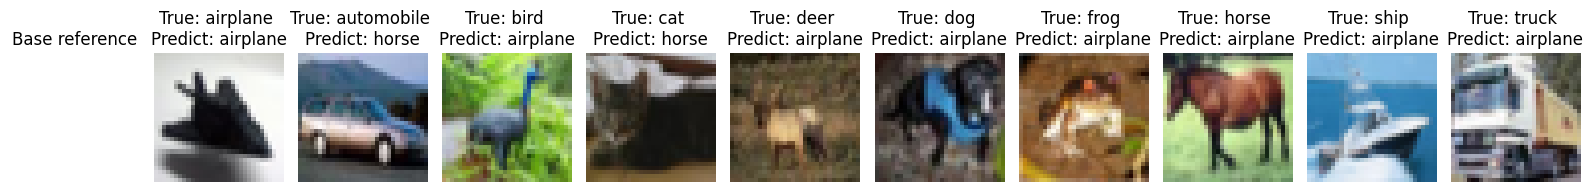

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

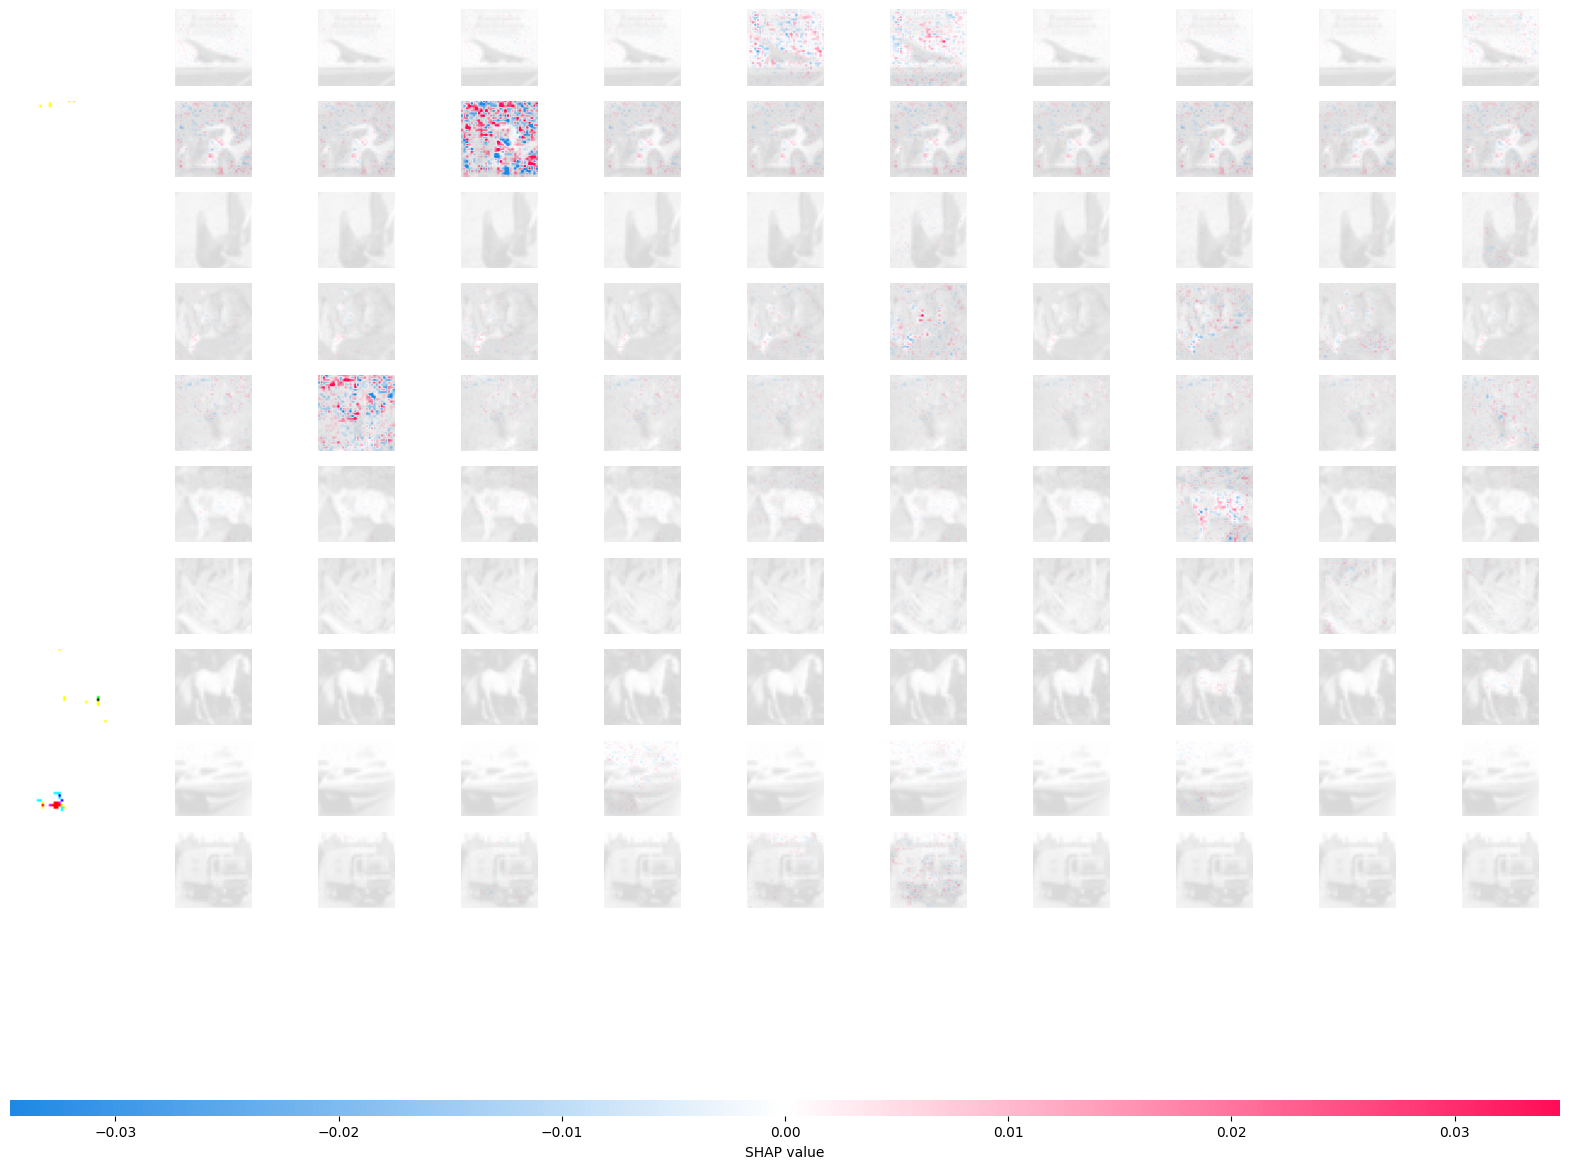

In [8]:
plot_actual_predicted(images_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class * 255)